In [1]:
#2000
import copy 
import os 
import itertools
from collections import Counter
import json
import pickle
import pprint
import pandas as pd
import numpy as np
res_dir = 'data-toggle/2000'
expdir = os.path.join(os.path.join(os.getcwd(), res_dir), 'causal_discovery')

In [2]:
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = [6, 8]

# Utility Functions 

In [3]:
def dataset_name_from_unid(uid):
    if 'adult' in uid:
        return 'adult'
    if 'german' in uid:
        return 'germanCredit'
    
    assert True == False 

In [4]:
def get_hps_from_rawres(fname):
    '''rawres fname -> features'''
    unique_id = (fname.split('rawres_')[1]).split('.json')[0]
    alpha = unique_id.split('_')[0]
    feateng = unique_id.split('_')[1]
    dataset = unique_id.split('_')[2]
    seed = unique_id.split('_')[3]
    environment = unique_id.split('_')[4]
    return feateng, dataset, seed, environment
    
     #print('{}_{}_{}_{}'.format(feateng, dataset, seed, environment))

In [5]:
def str_2_pcp(pcpstr):
    pcpstr = (pcpstr.split('(')[1]).split(')')[0]
    pcpstr = pcpstr.replace(' ', '')
    ret = set(pcpstr.split(','))
    ret.discard('')
    return ret

In [6]:
def eligible_exps(queries, e_list):
    '''Gets all experiments from e_list with the queries attributes
    param: elist: list of all posible expeirment keys 
    param: queries: list of terms which must be elements of e_list tuples'''
    ret = []
    for exp in e_list:
        flag = True
        for q in queries: 
            if q not in exp:
                flag = False
        if flag:
            ret.append(exp)
    return ret

In [7]:
def norm_ctr(Ctr, n):
    '''Returns sorted list (ctr_name, p) of the n most common elements in Ctr, where p is normalized freq'''
    sort = [list(x) for x in Ctr.most_common(n)]
    norm = len(list(Ctr.elements()))
    for t in sort:
        t[1] = t[1]/norm
    
    return sort 

def add_slist(s1, s2):
    'For all common-keyed tuples in s1-2, add prob values. For new ones, add to returned list'
    s1_keys = [x[0] for x in s1]
    ret = copy.deepcopy(s1)
    
    for t in s2: 
        if t[0] not in s1_keys:
            ret.append(t)
        else:
            for cp in ret:
                if cp[0] == t[0]:
                    cp[1] += t[1]
    return ret
    
def scale_slist(s, nf):
    for t in s:
        t[1] = t[1]/nf
    return s

def sqrt_slist(s):
    for t in s:
        t[1] = np.sqrt(t[1])
    return s

def sqdiff_slist(s1, means):
    '''For every value of m, find the (m, (s-m)^2)'''
    s1_keys = [s[0] for s in s1]
    ret = []
    
    for m in means:
        if m[0] in s1_keys: 
            for s in s1:
                if m[0] == s[0]:
                    ret.append([m[0], ((m[1]-s[1])**2)])
        else:
            ret.append([m[0], (m[1]**2)])
    
    return ret

def mean_slist(all_exps, results):
    '''For all specified experiments, find the list of (CPid, prob) for each and average them'''
    cp = []
    norm = len(all_exps)
    for exp in all_exps: 
        cp = add_slist(cp, norm_ctr(results[exp], None)) #Add the causal predictors to each 
    scaled = scale_slist(cp, norm)
    return sorted(scaled, key=lambda x:x[1], reverse=True)
        

def var_slist(all_exps, results):
    cp = []
    norm = len(all_exps)
    means = mean_slist(all_exps, results)
    
    for exp in all_exps: 
        cp = add_slist(cp, sqdiff_slist(norm_ctr(results[exp], None), means))

    cp = sqrt_slist(scale_slist(cp, norm))
    
    #Sort in same order as means 
    ret = []
    for m in means:
        for e in cp:
            if m[0] == e[0]:
                ret.append(e)
    
    return ret


In [22]:
import enum 
#Part 1
START_ALPHA = 1.0
FACTOR = 2
EPS = 1e-20
#Part 2
STEP = 1e-2
FACTOR2 = 2
EPS2 = 1e-10

class POS(enum.Enum):
   big = 1
   small = 2
   perf = 3

def alpha_tune(pVals, amin, flag=0):
    #First find a CP returning alpha 
    a0 = START_ALPHA
    bounds0 = [0, 100.0]
    cp_ret = False 
    while not cp_ret:
        pos = 0
        accepted = pVals[pVals['Final_tstat'] > a0]
        
        #Determine position of alpha 
        if len(accepted.index) == 0:
            pos = POS.big
        else: 
            accepted_sets = [str_2_pcp(a) for a in list(accepted.index)]
            causal_preds = set.intersection(*accepted_sets)
            if len(causal_preds) == 0:
                pos = POS.small 
            else:
                pos = POS.perf
                cp_ret = True
                continue
                
        #Determine what alpha to check next 
        if pos == POS.big:
            bounds0[1] = a0
            if a0/FACTOR <= bounds0[0]:
                a0 = a0 - abs((a0 - bounds0[0])/2)
            else:
                a0 = a0/FACTOR
        elif pos == POS.small:
            bounds0[0] = a0
            if a0 * FACTOR >= bounds0[1]:
                a0 = a0 + abs((a0 - bounds0[1])/2)
            else:
                a0 = a0 * FACTOR
        
        #Stability check in case no CPs 
        if abs(bounds0[0] - bounds0[1]) < EPS:
            return (-1, -1)
    
    #Then establish interval bounds 
    lowerB = [0, a0]
    upperB = [a0, 100]
    
    #Upper Bound
    a1 = a0
    step = STEP
    pos = POS.perf
    while abs(upperB[0] - upperB[1]) > EPS2:
        a1 = a1 + step
        accepted = pVals[pVals['Final_tstat'] > a1]
        
        #Determine position of alpha 
        if len(accepted.index) == 0:
            pos = POS.big
        else:
            pos = POS.perf
        
        #Determine what alpha to check next 
        if pos == POS.perf:
            upperB[0] = a1
            if a1 + abs(step * FACTOR2) >= upperB[1]:
                step = abs(a1 - upperB[1])/FACTOR2
            else:
                step = abs(step * FACTOR2) 
        elif pos == POS.big:
            upperB[1] = a1
            if (a1 - abs(step * FACTOR2)) <= upperB[0]:
                step = -1 * abs(a1 - upperB[0])/FACTOR2
            else:
                step = -1 * abs(step * FACTOR2) 
        else:
            assert False

    #Lower Bound
    a2 = a0
    if a2 - STEP > 1e-20:
        step = STEP
    else: 
        step = a2/FACTOR2 
    pos = POS.perf
    while abs(lowerB[0] - lowerB[1]) > EPS2:
        a2 = a2 - step
        accepted = pVals[pVals['Final_tstat'] > a2]
        
        #Determine position of alpha 
        accepted_sets = [str_2_pcp(a) for a in list(accepted.index)]
        causal_preds = set.intersection(*accepted_sets)
        if len(causal_preds) == 0:
            pos = POS.small 
        else:
            pos = POS.perf       
        
        #Determine what alpha to check next 
        if pos == POS.perf:
            lowerB[1] = a2
            if a2 - abs(step * FACTOR2) <= lowerB[0]:
                step = abs(a2 - lowerB[0])/FACTOR2
            else:
                step = abs(step * FACTOR2) 
        elif pos == POS.small:
            lowerB[0] = a2
            if (a1 + abs(step * FACTOR2)) >= lowerB[1]:
                step = -1 * abs(a2 - lowerB[1])/FACTOR2
            else:
                step = -1 * abs(step * FACTOR2) 
        else:
            assert False
    
    #Check if interval is too close to 0 to be meaningful 
    if flag:
        print(a2, a1)
    if a2 < amin: 
        return (-1, -1)
        
#     #Establish 0-padding to interval
#     interval = abs(a1 - a2)/5
    
#     return (max(0, a2 - interval), a1 + interval)
    return (a2, a1)


# # File Generation

In [9]:
#Collect all files appropiate to each unique identifier 
rawres_files= []
for f in os.listdir(expdir):
    if ('rawres_' in f):
        rawres_files.append(f)

# Parameters

In [23]:
#Generate Alphas 
NUM_POINTS = 100
MIN_ALPHA = 1e-4

alphas = {}
for fname in rawres_files:
    f, d, s, e = get_hps_from_rawres(fname) 
    
    unid = '{}_{}_{}_{}'.format(f,d,s,e)
    try:
        pvals = json.load(open(os.path.join(expdir, fname), 'rb'))
        del pvals["()"]
    except:
        continue
    pvals = pd.DataFrame.from_dict(pvals, orient='index')
    alphas[(s, d, e)] = [x for x in alpha_tune(pvals, MIN_ALPHA)] + [NUM_POINTS]
    if (s == '587' and e =='native-country'):
        print(alpha_tune(pvals, MIN_ALPHA, flag=1))
    
alphas = pd.DataFrame(alphas).T
alphas.columns = ['start', 'stop', 'num_points']
alphas.index.names = ['seed', 'dataset', 'env']
alphas.head(1000)

0.05300824297592044 0.3285490188747643
(0.05300824297592044, 0.3285490188747643)


start      stop  num_points
seed dataset env                                           
1000 adult   marital-status -1.000000 -1.000000       100.0
             native-country  0.024673  0.068833       100.0
             occupation     -1.000000 -1.000000       100.0
             relationship   -1.000000 -1.000000       100.0
             workclass       0.142960  0.562638       100.0
147  adult   marital-status -1.000000 -1.000000       100.0
             native-country  0.141345  0.159281       100.0
             occupation     -1.000000 -1.000000       100.0
             relationship   -1.000000 -1.000000       100.0
             workclass       0.131917  0.258429       100.0
256  adult   marital-status -1.000000 -1.000000       100.0
             native-country  0.422670  1.396775       100.0
             occupation     -1.000000 -1.000000       100.0
             relationship   -1.000000 -1.000000       100.0
             workclass       0.107148  0.349363       100.0
304  adult   marital-status -1.000000 -1.000000       100.0
             native-country  0.053182  0.191517       100.0
             occupation     -1.000000 -1.000000       100.0
             relationship   -1.000000 -1.000000       100.0
             workclass       0.179067  0.407294       100.0
52   adult   marital-status -1.000000 -1.000000       100.0
             native-country  0.173714  1.985901       100.0
             occupation     -1.000000 -1.000000       100.0
             relationship   -1.000000 -1.000000       100.0
             workclass       0.116937  0.240611       100.0
587  adult   marital-status -1.000000 -1.000000       100.0
             native-country  0.053008  0.328549       100.0
             occupation     -1.000000 -1.000000       100.0
             relationship   -1.000000 -1.000000       100.0
             workclass       0.171480  0.234317       100.0
737  adult   marital-status -1.000000 -1.000000       100.0
             native-country  0.108214  0.505530       100.0
             occupation     -1.000000 -1.000000       100.0
             relationship   -1.000000 -1.000000       100.0
             workclass       0.150341  0.185804       100.0
784  adult   marital-status -1.000000 -1.000000       100.0
             native-country  0.060482  0.470696       100.0
             occupation     -1.000000 -1.000000       100.0
             relationship   -1.000000 -1.000000       100.0
             workclass       0.440704  1.124714       100.0
8079 adult   marital-status -1.000000 -1.000000       100.0
             native-country  0.434909  1.051869       100.0
             occupation     -1.000000 -1.000000       100.0
             relationship   -1.000000 -1.000000       100.0
             workclass       0.109792  0.496127       100.0
990  adult   marital-status -1.000000 -1.000000       100.0
             native-country  0.139627  0.286626       100.0
             occupation     -1.000000 -1.000000       100.0
             relationship   -1.000000 -1.000000       100.0
             workclass       0.117161  0.712849       100.0

In [24]:
feateng = ['12']
dataset = ['adult']  #['adult', germanCredit']
seed = [str(x) for x in set(alphas.index.get_level_values(0))]  #, '8079', '52', '147', '256', '784', '990', '587', '304','737']
environment = [str(x) for x in set(alphas.index.get_level_values(2))] 

available_exps = itertools.product(feateng, dataset, seed, environment)

# Number PCPS Accepted

In [25]:
x_axis = {}  #x,y values  for plot of alpha vs #CPs 
y_axis = {}
CPid_results = {}  #Stores CPids of each expierment 
# assert len(list(itertools.product(feateng, dataset, seed, environment))) == 1

for exp in available_exps:
    for fname in rawres_files:
        f, d, s, e = get_hps_from_rawres(fname)  
        if (f == exp[0]) and (d == exp[1]) and (s == exp[2]) and (e == exp[3]):
            unid = '{}_{}_{}_{}'.format(f,d,s,e)
            try:
                pvals = json.load(open(os.path.join(expdir, fname), 'rb'))
                del pvals["()"]
            except:
                continue
            pvals = pd.DataFrame.from_dict(pvals, orient='index')
            
            #For Storing all the results 
            x_axis[(s, d, e)] = []
            y_axis[(s, d, e)] = []
            CPid_results[(s, d, e)] = Counter()
            norm = 0
            
            start, stop, num_points = alphas.loc[s, d, e][0], alphas.loc[s, d, e][1], alphas.loc[s, d, e][2]
            for a in np.linspace(start, stop, num_points): 
                accepted = pvals[pvals['Final_tstat'] > a]
                if len(accepted.index) > 100000:
                    raise ValueError('too many subsets: {}'.format(len(accepted.index)))
                
                accepted_sets = list(accepted.index)
                accepted_sets = [str_2_pcp(a) for a in accepted_sets]
                if len(accepted_sets) > 0:
                    pcps = set.intersection(*accepted_sets)
                else:
                    pcps = set([])
                
                #Number of Accepted Sets 
                x_axis[(s, d, e)].append(a)
                if len(accepted_sets) == 0:
                    y_axis[(s, d, e)].append(0)
                else:
                    y_axis[(s, d, e)].append(len(set.intersection(*accepted_sets)))
                    
                #Causal predictor  
                for pcp in pcps: 
                    CPid_results[(s, d, e)].update({pcp:1})



/Users/RobertAdragna/Documents/School/Fourth_Year/ESC499-Thesis/codebases/thesisenv/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


In [26]:
len(x_axis.keys())

50

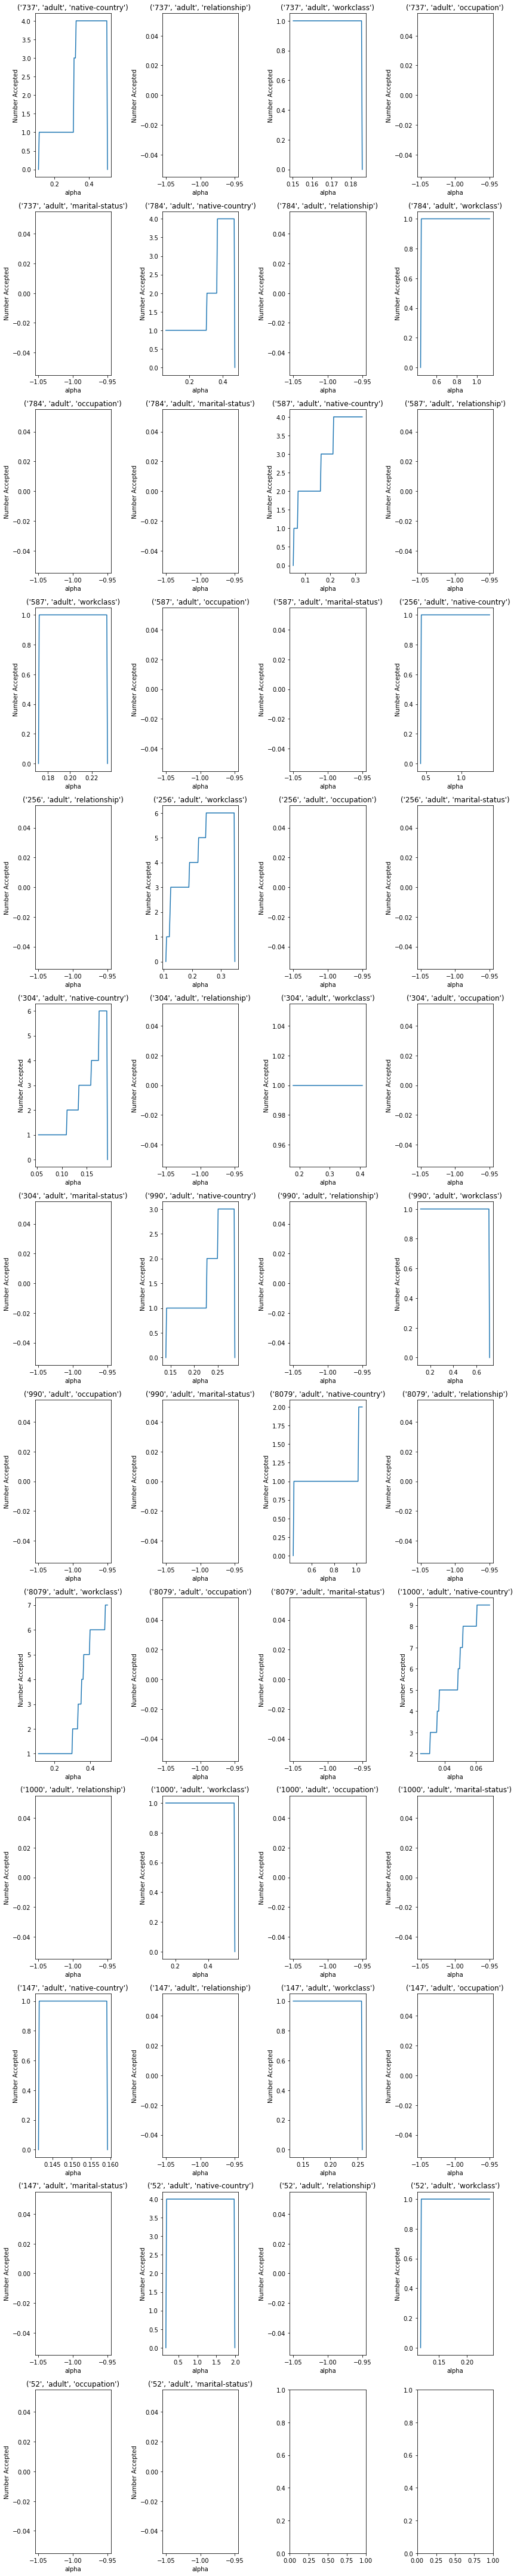

In [27]:
#matplotlib.rcParams.update({'font.size': 12})
NCOLS = 4
NROWS = int(len(x_axis.keys())/NCOLS)
fig, axes = plt.subplots(NROWS + 1, ncols=NCOLS, figsize=(NCOLS*3, NROWS*5))

for i, exp in enumerate(x_axis.keys()):  #Assume x_axis, y_axis keys are the same 
    axes[int(i/4), i%4].plot(x_axis[exp], y_axis[exp])
    axes[int(i/4), i%4].set_title(exp)
    axes[int(i/4), i%4].set_ylabel('Number Accepted')
    axes[int(i/4), i%4].set_xlabel('alpha')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.tight_layout()
plt.show()


# ALPHA SENSITIVITY PLOTS

##Regular

In [28]:
# colours = ['b', 'g', 'r', 'c', 'k']
# matplotlib.rcParams.update({'font.size': 16})
# fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(40, 20))

# for i, exp in enumerate(CPid_results.keys()):
#     sort_pcp_sens = norm_ctr(CPid_results[exp], 5)    
    
#     labels = []
#     bars = []
#     for d in range(min(5,len(sort_pcp_sens))):
#         labels.append(sort_pcp_sens[d][0])
#         bars.append(sort_pcp_sens[d][1])


#     X = 0 
#     width = 0.05  # the width of the bars
    
#     axes[int(i/4), i%4].set_title(exp, pad=30)
#     if (i%4) == 0:
#         axes[int(i/4), i%4].set_ylabel('Proportion Included', fontsize=32)
#         axes[int(i/4), i%4].yaxis.labelpad = 40
#     axes[int(i/4), i%4].set_ylim(0,1)
#     axes[int(i/4), i%4].tick_params(
#         axis='x',          # changes apply to the x-axis
#         which='both',      # both major and minor ticks are affected
#         bottom=False,      # ticks along the bottom edge are off
#         top=False,         # ticks along the top edge are off
#         labelbottom=False) # labels along the 
    
#     for d in range(len(labels)):
#         axes[int(i/4), i%4].bar(X + (d*width), bars[d], color = colours[d], width = width, label=labels[d])
#     axes[int(i/4), i%4].legend(loc='lower left', prop={'size':30}) 

# plt.show()

In [29]:
print(CPid_results.keys())

dict_keys([('737', 'adult', 'native-country'), ('737', 'adult', 'relationship'), ('737', 'adult', 'workclass'), ('737', 'adult', 'occupation'), ('737', 'adult', 'marital-status'), ('784', 'adult', 'native-country'), ('784', 'adult', 'relationship'), ('784', 'adult', 'workclass'), ('784', 'adult', 'occupation'), ('784', 'adult', 'marital-status'), ('587', 'adult', 'native-country'), ('587', 'adult', 'relationship'), ('587', 'adult', 'workclass'), ('587', 'adult', 'occupation'), ('587', 'adult', 'marital-status'), ('256', 'adult', 'native-country'), ('256', 'adult', 'relationship'), ('256', 'adult', 'workclass'), ('256', 'adult', 'occupation'), ('256', 'adult', 'marital-status'), ('304', 'adult', 'native-country'), ('304', 'adult', 'relationship'), ('304', 'adult', 'workclass'), ('304', 'adult', 'occupation'), ('304', 'adult', 'marital-status'), ('990', 'adult', 'native-country'), ('990', 'adult', 'relationship'), ('990', 'adult', 'workclass'), ('990', 'adult', 'occupation'), ('990', 'ad

##Aggregate Random Seeds

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


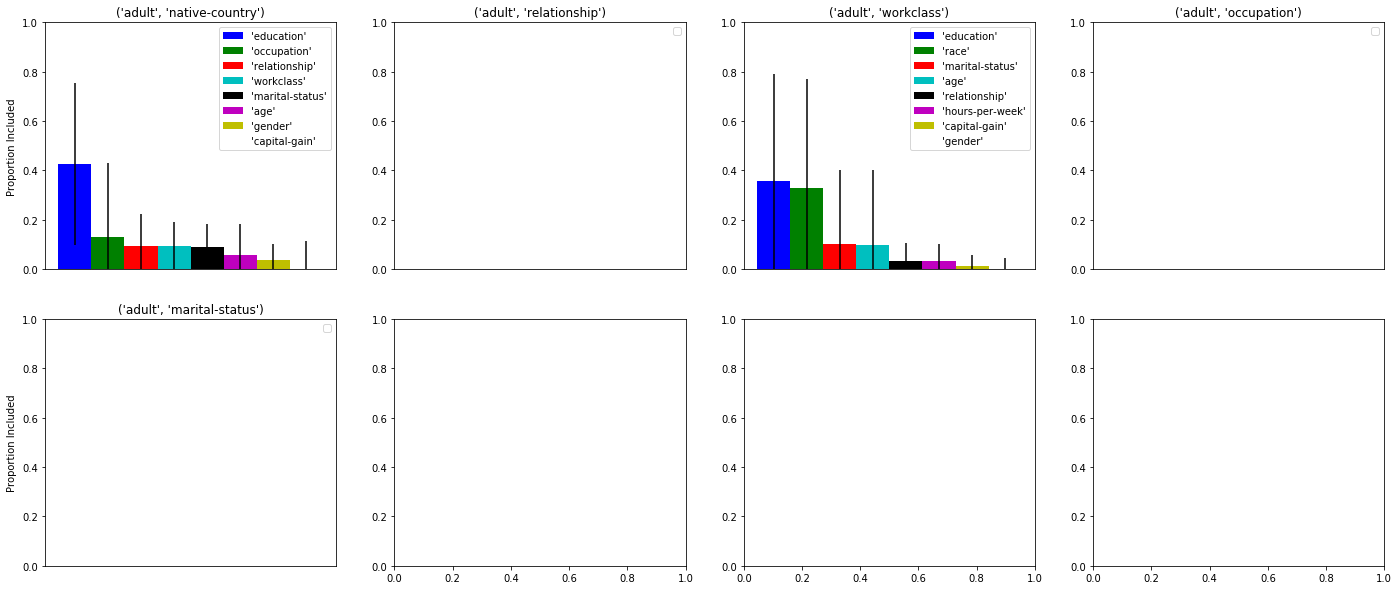

In [30]:
colours = ['b', 'g', 'r', 'c', 'k', 'm', 'y', 'w']
# matplotlib.rcParams.update({'font.size': 16})

NCOLS = 4
NROWS = int(len(list(itertools.product(dataset, environment)))/NCOLS)
fig, axes = plt.subplots(NROWS + 1, ncols=NCOLS, figsize=(NCOLS*6, NROWS*10))

for i, big_exp in enumerate(list(itertools.product(dataset, environment))):
    avg_sort_pcp_sens = mean_slist(eligible_exps(big_exp, CPid_results.keys()), CPid_results)
    errors = var_slist(eligible_exps(big_exp, CPid_results.keys()), CPid_results)
    
    labels = []
    bars = []
    errors_plt = []
    for d in range(min(8,len(avg_sort_pcp_sens))):
        labels.append(avg_sort_pcp_sens[d][0])
        bars.append(avg_sort_pcp_sens[d][1])
        errors_plt.append(errors[d][1])

    X = 0 
    width = 0.05  # the width of the bars

    axes[int(i/4), i%4].set_title(big_exp)  #, pad=30)
    if (i%4) == 0:
        axes[int(i/4), i%4].set_ylabel('Proportion Included') #, fontsize=32)
        axes[int(i/4), i%4].yaxis.labelpad = 5
    axes[int(i/4), i%4].set_ylim(0,1)
    axes[int(i/4), i%4].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the 

    for d in range(len(labels)):
        axes[int(i/4), i%4].bar(X + (d*width), bars[d], color = colours[d], \
                                width = width, label=labels[d], yerr=errors_plt[d])
    axes[int(i/4), i%4].legend(loc='upper right')  #, prop={'size':30}) 

plt.show()

## Confusion Matrix

In [31]:
all_consmats = []  #consmats for all (dataset, seed) combos

#Get the consistency matrix for each seed
for big_exp in list(itertools.product(dataset, seed)):  #enumerates through each random seed 
    env_exps = eligible_exps(big_exp, CPid_results.keys())
    res = np.zeros([len(environment), len(environment)])
    for i, env_1 in enumerate(env_exps):
        for j, env_2 in enumerate(env_exps):
            if i <= j:
                e1 = set([x[0] for x in norm_ctr(CPid_results[env_1], 5)])
                e2 = set([x[0] for x in norm_ctr(CPid_results[env_2], 5)])
                #Jaccard
                if (len(set.intersection(e1, e2)) == 0) and (len(set.union(e1, e2)) == 0):
                    res[i,j] = 1
                else:
                    res[i,j] = len(set.intersection(e1, e2))/len(set.union(e1, e2))

    all_consmats.append(res)

#Compute mean, variance of consistency matrix 
mean_consmat = (sum(all_consmats)/len(all_consmats)).round(decimals=2)
std_consmat = np.zeros([len(environment), len(environment)])
for cm in all_consmats:
    std_consmat += np.square((cm - mean_consmat))
std_consmat = np.sqrt(std_consmat/len(all_consmats)).round(decimals=2)

consmat = pd.DataFrame(mean_consmat, index=environment, columns=environment).applymap(str).apply( \
              lambda x: x + ' +- ') + pd.DataFrame(std_consmat, index=environment, columns=environment).applymap(str)  
consmat.style





,native-country,relationship,workclass,occupation,marital-status
native-country,1.0 +- 0.0,0.0 +- 0.0,0.11 +- 0.12,0.0 +- 0.0,0.0 +- 0.0
relationship,0.0 +- 0.0,1.0 +- 0.0,0.0 +- 0.0,1.0 +- 0.0,1.0 +- 0.0
workclass,0.0 +- 0.0,0.0 +- 0.0,1.0 +- 0.0,0.0 +- 0.0,0.0 +- 0.0
occupation,0.0 +- 0.0,0.0 +- 0.0,0.0 +- 0.0,1.0 +- 0.0,1.0 +- 0.0
marital-status,0.0 +- 0.0,0.0 +- 0.0,0.0 +- 0.0,0.0 +- 0.0,1.0 +- 0.0


# Appendix

## CALIBRATION

In [32]:
# #Plot Accepted subsets vs Alpha for specified hyperparams 

# #fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(w*5, int(l/w)*5)) #Note - is +2 for reason


for exp in itertools.product(feateng, dataset, seed, environment):
    for fname in rawres_files:
        f, d, s, e = get_hps_from_rawres(fname)
        if (f == exp[0]) and (d == exp[1]) and (s == exp[2]) and (e == exp[3]):
            unid = '{}_{}_{}_{}'.format(f,d,s,e)
            try:
                pvals = json.load(open(os.path.join(expdir, fname), 'rb'))
                del pvals["()"]
            except:
                continue
            pvals = pd.DataFrame.from_dict(pvals, orient='index')
            
            start, stop, num_points = alphas.loc[s, d, e][0], alphas.loc[s, d, e][1], alphas.loc[s, d, e][2]
            for a in np.linspace(start, stop, num_points): 
                accepted = pvals[pvals['Final_tstat'] > a]
                if len(accepted.index) == 0:
                    print(a, unid, 0, 'null')
                elif len(accepted.index) < 1000:
                    accepted_sets = list(accepted.index)
                    accepted_sets = [str_2_pcp(a) for a in accepted_sets]
                    print(a, unid, len(accepted.index), set.intersection(*accepted_sets))
                else:
                    print(a, unid, len(accepted.index), 'too_many_intersections')
            
    
    print('#####################################')

/Users/RobertAdragna/Documents/School/Fourth_Year/ESC499-Thesis/codebases/thesisenv/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


0.10821385848801582 12_adult_737_native-country 17 set()
0.11222715688916393 12_adult_737_native-country 16 {"'education'"}
0.11624045529031203 12_adult_737_native-country 14 {"'education'"}
0.12025375369146014 12_adult_737_native-country 14 {"'education'"}
0.12426705209260824 12_adult_737_native-country 14 {"'education'"}
0.12828035049375636 12_adult_737_native-country 12 {"'education'"}
0.13229364889490447 12_adult_737_native-country 12 {"'education'"}
0.13630694729605258 12_adult_737_native-country 10 {"'education'"}
0.1403202456972007 12_adult_737_native-country 10 {"'education'"}
0.14433354409834878 12_adult_737_native-country 10 {"'education'"}
0.1483468424994969 12_adult_737_native-country 10 {"'education'"}
0.152360140900645 12_adult_737_native-country 9 {"'education'"}
0.15637343930179312 12_adult_737_native-country 9 {"'education'"}
0.1603867377029412 12_adult_737_native-country 8 {"'education'"}
0.16440003610408932 12_adult_737_native-country 8 {"'education'"}
0.168413334505

-1.0 12_adult_737_relationship 2047 too_many_intersections
-1.0 12_adult_737_relationship 2047 too_many_intersections
-1.0 12_adult_737_relationship 2047 too_many_intersections
-1.0 12_adult_737_relationship 2047 too_many_intersections
-1.0 12_adult_737_relationship 2047 too_many_intersections
-1.0 12_adult_737_relationship 2047 too_many_intersections
-1.0 12_adult_737_relationship 2047 too_many_intersections
-1.0 12_adult_737_relationship 2047 too_many_intersections
-1.0 12_adult_737_relationship 2047 too_many_intersections
-1.0 12_adult_737_relationship 2047 too_many_intersections
-1.0 12_adult_737_relationship 2047 too_many_intersections
-1.0 12_adult_737_relationship 2047 too_many_intersections
-1.0 12_adult_737_relationship 2047 too_many_intersections
-1.0 12_adult_737_relationship 2047 too_many_intersections
-1.0 12_adult_737_relationship 2047 too_many_intersections
-1.0 12_adult_737_relationship 2047 too_many_intersections
-1.0 12_adult_737_relationship 2047 too_many_intersectio

0.18043058813747131 12_adult_737_workclass 1 {"'race'"}
0.18078879335086154 12_adult_737_workclass 1 {"'race'"}
0.18114699856425176 12_adult_737_workclass 1 {"'race'"}
0.18150520377764198 12_adult_737_workclass 1 {"'race'"}
0.1818634089910322 12_adult_737_workclass 1 {"'race'"}
0.1822216142044224 12_adult_737_workclass 1 {"'race'"}
0.18257981941781262 12_adult_737_workclass 1 {"'race'"}
0.18293802463120284 12_adult_737_workclass 1 {"'race'"}
0.18329622984459304 12_adult_737_workclass 1 {"'race'"}
0.1836544350579833 12_adult_737_workclass 1 {"'race'"}
0.18401264027137348 12_adult_737_workclass 1 {"'race'"}
0.1843708454847637 12_adult_737_workclass 1 {"'race'"}
0.18472905069815393 12_adult_737_workclass 1 {"'race'"}
0.18508725591154412 12_adult_737_workclass 1 {"'race'"}
0.18544546112493435 12_adult_737_workclass 1 {"'race'"}
0.18580366633832457 12_adult_737_workclass 0 null
#####################################
-1.0 12_adult_737_occupation 2047 too_many_intersections
-1.0 12_adult_737_o

0.15164068354707624 12_adult_784_native-country 43 {"'education'"}
0.15578425674877985 12_adult_784_native-country 39 {"'education'"}
0.15992782995048346 12_adult_784_native-country 38 {"'education'"}
0.16407140315218705 12_adult_784_native-country 34 {"'education'"}
0.16821497635389066 12_adult_784_native-country 32 {"'education'"}
0.17235854955559426 12_adult_784_native-country 31 {"'education'"}
0.17650212275729787 12_adult_784_native-country 30 {"'education'"}
0.18064569595900148 12_adult_784_native-country 28 {"'education'"}
0.1847892691607051 12_adult_784_native-country 27 {"'education'"}
0.18893284236240868 12_adult_784_native-country 26 {"'education'"}
0.19307641556411229 12_adult_784_native-country 25 {"'education'"}
0.1972199887658159 12_adult_784_native-country 24 {"'education'"}
0.2013635619675195 12_adult_784_native-country 24 {"'education'"}
0.2055071351692231 12_adult_784_native-country 23 {"'education'"}
0.2096507083709267 12_adult_784_native-country 22 {"'education'"}


-1.0 12_adult_784_relationship 2047 too_many_intersections
-1.0 12_adult_784_relationship 2047 too_many_intersections
-1.0 12_adult_784_relationship 2047 too_many_intersections
-1.0 12_adult_784_relationship 2047 too_many_intersections
-1.0 12_adult_784_relationship 2047 too_many_intersections
-1.0 12_adult_784_relationship 2047 too_many_intersections
-1.0 12_adult_784_relationship 2047 too_many_intersections
-1.0 12_adult_784_relationship 2047 too_many_intersections
-1.0 12_adult_784_relationship 2047 too_many_intersections
-1.0 12_adult_784_relationship 2047 too_many_intersections
-1.0 12_adult_784_relationship 2047 too_many_intersections
-1.0 12_adult_784_relationship 2047 too_many_intersections
-1.0 12_adult_784_relationship 2047 too_many_intersections
-1.0 12_adult_784_relationship 2047 too_many_intersections
-1.0 12_adult_784_relationship 2047 too_many_intersections
-1.0 12_adult_784_relationship 2047 too_many_intersections
-1.0 12_adult_784_relationship 2047 too_many_intersectio

-1.0 12_adult_784_occupation 2047 too_many_intersections
-1.0 12_adult_784_occupation 2047 too_many_intersections
-1.0 12_adult_784_occupation 2047 too_many_intersections
-1.0 12_adult_784_occupation 2047 too_many_intersections
-1.0 12_adult_784_occupation 2047 too_many_intersections
-1.0 12_adult_784_occupation 2047 too_many_intersections
-1.0 12_adult_784_occupation 2047 too_many_intersections
-1.0 12_adult_784_occupation 2047 too_many_intersections
-1.0 12_adult_784_occupation 2047 too_many_intersections
-1.0 12_adult_784_occupation 2047 too_many_intersections
-1.0 12_adult_784_occupation 2047 too_many_intersections
-1.0 12_adult_784_occupation 2047 too_many_intersections
-1.0 12_adult_784_occupation 2047 too_many_intersections
-1.0 12_adult_784_occupation 2047 too_many_intersections
-1.0 12_adult_784_occupation 2047 too_many_intersections
-1.0 12_adult_784_occupation 2047 too_many_intersections
-1.0 12_adult_784_occupation 2047 too_many_intersections
-1.0 12_adult_784_occupation 20

0.28123393614465975 12_adult_587_native-country 1 {"'gender'", "'marital-status'", "'relationship'", "'education'"}
0.28401717630525414 12_adult_587_native-country 1 {"'gender'", "'marital-status'", "'relationship'", "'education'"}
0.28680041646584853 12_adult_587_native-country 1 {"'gender'", "'marital-status'", "'relationship'", "'education'"}
0.2895836566264429 12_adult_587_native-country 1 {"'gender'", "'marital-status'", "'relationship'", "'education'"}
0.2923668967870373 12_adult_587_native-country 1 {"'gender'", "'marital-status'", "'relationship'", "'education'"}
0.2951501369476317 12_adult_587_native-country 1 {"'gender'", "'marital-status'", "'relationship'", "'education'"}
0.2979333771082261 12_adult_587_native-country 1 {"'gender'", "'marital-status'", "'relationship'", "'education'"}
0.3007166172688205 12_adult_587_native-country 1 {"'gender'", "'marital-status'", "'relationship'", "'education'"}
0.3034998574294148 12_adult_587_native-country 1 {"'gender'", "'marital-statu

0.18353979303153473 12_adult_587_workclass 1 {"'race'"}
0.1841745111564494 12_adult_587_workclass 1 {"'race'"}
0.18480922928136403 12_adult_587_workclass 1 {"'race'"}
0.1854439474062787 12_adult_587_workclass 1 {"'race'"}
0.18607866553119334 12_adult_587_workclass 1 {"'race'"}
0.186713383656108 12_adult_587_workclass 1 {"'race'"}
0.18734810178102265 12_adult_587_workclass 1 {"'race'"}
0.1879828199059373 12_adult_587_workclass 1 {"'race'"}
0.18861753803085196 12_adult_587_workclass 1 {"'race'"}
0.1892522561557666 12_adult_587_workclass 1 {"'race'"}
0.18988697428068124 12_adult_587_workclass 1 {"'race'"}
0.1905216924055959 12_adult_587_workclass 1 {"'race'"}
0.19115641053051055 12_adult_587_workclass 1 {"'race'"}
0.19179112865542522 12_adult_587_workclass 1 {"'race'"}
0.19242584678033986 12_adult_587_workclass 1 {"'race'"}
0.1930605649052545 12_adult_587_workclass 1 {"'race'"}
0.19369528303016917 12_adult_587_workclass 1 {"'race'"}
0.1943300011550838 12_adult_587_workclass 1 {"'race'"}
0

-1.0 12_adult_587_marital-status 2047 too_many_intersections
-1.0 12_adult_587_marital-status 2047 too_many_intersections
-1.0 12_adult_587_marital-status 2047 too_many_intersections
-1.0 12_adult_587_marital-status 2047 too_many_intersections
-1.0 12_adult_587_marital-status 2047 too_many_intersections
-1.0 12_adult_587_marital-status 2047 too_many_intersections
-1.0 12_adult_587_marital-status 2047 too_many_intersections
-1.0 12_adult_587_marital-status 2047 too_many_intersections
-1.0 12_adult_587_marital-status 2047 too_many_intersections
-1.0 12_adult_587_marital-status 2047 too_many_intersections
-1.0 12_adult_587_marital-status 2047 too_many_intersections
-1.0 12_adult_587_marital-status 2047 too_many_intersections
-1.0 12_adult_587_marital-status 2047 too_many_intersections
-1.0 12_adult_587_marital-status 2047 too_many_intersections
-1.0 12_adult_587_marital-status 2047 too_many_intersections
-1.0 12_adult_587_marital-status 2047 too_many_intersections
-1.0 12_adult_587_marita

-1.0 12_adult_256_relationship 2047 too_many_intersections
-1.0 12_adult_256_relationship 2047 too_many_intersections
-1.0 12_adult_256_relationship 2047 too_many_intersections
-1.0 12_adult_256_relationship 2047 too_many_intersections
-1.0 12_adult_256_relationship 2047 too_many_intersections
-1.0 12_adult_256_relationship 2047 too_many_intersections
-1.0 12_adult_256_relationship 2047 too_many_intersections
-1.0 12_adult_256_relationship 2047 too_many_intersections
-1.0 12_adult_256_relationship 2047 too_many_intersections
-1.0 12_adult_256_relationship 2047 too_many_intersections
-1.0 12_adult_256_relationship 2047 too_many_intersections
-1.0 12_adult_256_relationship 2047 too_many_intersections
-1.0 12_adult_256_relationship 2047 too_many_intersections
-1.0 12_adult_256_relationship 2047 too_many_intersections
-1.0 12_adult_256_relationship 2047 too_many_intersections
-1.0 12_adult_256_relationship 2047 too_many_intersections
-1.0 12_adult_256_relationship 2047 too_many_intersectio

0.25883789197889845 12_adult_256_workclass 2 {"'race'", "'relationship'", "'education'", "'capital-loss'", "'capital-gain'", "'hours-per-week'"}
0.26128451016138904 12_adult_256_workclass 2 {"'race'", "'relationship'", "'education'", "'capital-loss'", "'capital-gain'", "'hours-per-week'"}
0.2637311283438796 12_adult_256_workclass 2 {"'race'", "'relationship'", "'education'", "'capital-loss'", "'capital-gain'", "'hours-per-week'"}
0.26617774652637016 12_adult_256_workclass 2 {"'race'", "'relationship'", "'education'", "'capital-loss'", "'capital-gain'", "'hours-per-week'"}
0.26862436470886075 12_adult_256_workclass 2 {"'race'", "'relationship'", "'education'", "'capital-loss'", "'capital-gain'", "'hours-per-week'"}
0.2710709828913513 12_adult_256_workclass 2 {"'race'", "'relationship'", "'education'", "'capital-loss'", "'capital-gain'", "'hours-per-week'"}
0.2735176010738419 12_adult_256_workclass 2 {"'race'", "'relationship'", "'education'", "'capital-loss'", "'capital-gain'", "'hours-

-1.0 12_adult_256_occupation 2047 too_many_intersections
-1.0 12_adult_256_occupation 2047 too_many_intersections
-1.0 12_adult_256_occupation 2047 too_many_intersections
-1.0 12_adult_256_occupation 2047 too_many_intersections
-1.0 12_adult_256_occupation 2047 too_many_intersections
-1.0 12_adult_256_occupation 2047 too_many_intersections
-1.0 12_adult_256_occupation 2047 too_many_intersections
-1.0 12_adult_256_occupation 2047 too_many_intersections
-1.0 12_adult_256_occupation 2047 too_many_intersections
-1.0 12_adult_256_occupation 2047 too_many_intersections
-1.0 12_adult_256_occupation 2047 too_many_intersections
-1.0 12_adult_256_occupation 2047 too_many_intersections
-1.0 12_adult_256_occupation 2047 too_many_intersections
-1.0 12_adult_256_occupation 2047 too_many_intersections
-1.0 12_adult_256_occupation 2047 too_many_intersections
-1.0 12_adult_256_occupation 2047 too_many_intersections
-1.0 12_adult_256_occupation 2047 too_many_intersections
-1.0 12_adult_256_occupation 20

-1.0 12_adult_304_relationship 2047 too_many_intersections
-1.0 12_adult_304_relationship 2047 too_many_intersections
-1.0 12_adult_304_relationship 2047 too_many_intersections
-1.0 12_adult_304_relationship 2047 too_many_intersections
-1.0 12_adult_304_relationship 2047 too_many_intersections
-1.0 12_adult_304_relationship 2047 too_many_intersections
-1.0 12_adult_304_relationship 2047 too_many_intersections
-1.0 12_adult_304_relationship 2047 too_many_intersections
-1.0 12_adult_304_relationship 2047 too_many_intersections
-1.0 12_adult_304_relationship 2047 too_many_intersections
-1.0 12_adult_304_relationship 2047 too_many_intersections
-1.0 12_adult_304_relationship 2047 too_many_intersections
-1.0 12_adult_304_relationship 2047 too_many_intersections
-1.0 12_adult_304_relationship 2047 too_many_intersections
-1.0 12_adult_304_relationship 2047 too_many_intersections
-1.0 12_adult_304_relationship 2047 too_many_intersections
-1.0 12_adult_304_relationship 2047 too_many_intersectio

-1.0 12_adult_304_occupation 2047 too_many_intersections
-1.0 12_adult_304_occupation 2047 too_many_intersections
-1.0 12_adult_304_occupation 2047 too_many_intersections
-1.0 12_adult_304_occupation 2047 too_many_intersections
-1.0 12_adult_304_occupation 2047 too_many_intersections
-1.0 12_adult_304_occupation 2047 too_many_intersections
-1.0 12_adult_304_occupation 2047 too_many_intersections
-1.0 12_adult_304_occupation 2047 too_many_intersections
-1.0 12_adult_304_occupation 2047 too_many_intersections
-1.0 12_adult_304_occupation 2047 too_many_intersections
-1.0 12_adult_304_occupation 2047 too_many_intersections
-1.0 12_adult_304_occupation 2047 too_many_intersections
-1.0 12_adult_304_occupation 2047 too_many_intersections
-1.0 12_adult_304_occupation 2047 too_many_intersections
-1.0 12_adult_304_occupation 2047 too_many_intersections
-1.0 12_adult_304_occupation 2047 too_many_intersections
-1.0 12_adult_304_occupation 2047 too_many_intersections
-1.0 12_adult_304_occupation 20

0.24505089142632602 12_adult_990_native-country 2 {"'relationship'", "'education'"}
0.24653573347086255 12_adult_990_native-country 2 {"'relationship'", "'education'"}
0.24802057551539905 12_adult_990_native-country 2 {"'relationship'", "'education'"}
0.24950541755993555 12_adult_990_native-country 2 {"'relationship'", "'education'"}
0.2509902596044721 12_adult_990_native-country 1 {"'marital-status'", "'relationship'", "'education'"}
0.2524751016490086 12_adult_990_native-country 1 {"'marital-status'", "'relationship'", "'education'"}
0.25395994369354513 12_adult_990_native-country 1 {"'marital-status'", "'relationship'", "'education'"}
0.2554447857380816 12_adult_990_native-country 1 {"'marital-status'", "'relationship'", "'education'"}
0.25692962778261813 12_adult_990_native-country 1 {"'marital-status'", "'relationship'", "'education'"}
0.25841446982715466 12_adult_990_native-country 1 {"'marital-status'", "'relationship'", "'education'"}
0.25989931187169113 12_adult_990_native-cou

0.1532633274953078 12_adult_990_workclass 1 {"'education'"}
0.15928038081229481 12_adult_990_workclass 1 {"'education'"}
0.1652974341292818 12_adult_990_workclass 1 {"'education'"}
0.1713144874462688 12_adult_990_workclass 1 {"'education'"}
0.1773315407632558 12_adult_990_workclass 1 {"'education'"}
0.1833485940802428 12_adult_990_workclass 1 {"'education'"}
0.18936564739722977 12_adult_990_workclass 1 {"'education'"}
0.19538270071421676 12_adult_990_workclass 1 {"'education'"}
0.20139975403120375 12_adult_990_workclass 1 {"'education'"}
0.20741680734819076 12_adult_990_workclass 1 {"'education'"}
0.21343386066517775 12_adult_990_workclass 1 {"'education'"}
0.21945091398216474 12_adult_990_workclass 1 {"'education'"}
0.22546796729915175 12_adult_990_workclass 1 {"'education'"}
0.23148502061613874 12_adult_990_workclass 1 {"'education'"}
0.23750207393312572 12_adult_990_workclass 1 {"'education'"}
0.2435191272501127 12_adult_990_workclass 1 {"'education'"}
0.24953618056709972 12_adult_9

-1.0 12_adult_990_marital-status 2047 too_many_intersections
-1.0 12_adult_990_marital-status 2047 too_many_intersections
-1.0 12_adult_990_marital-status 2047 too_many_intersections
-1.0 12_adult_990_marital-status 2047 too_many_intersections
-1.0 12_adult_990_marital-status 2047 too_many_intersections
-1.0 12_adult_990_marital-status 2047 too_many_intersections
-1.0 12_adult_990_marital-status 2047 too_many_intersections
-1.0 12_adult_990_marital-status 2047 too_many_intersections
-1.0 12_adult_990_marital-status 2047 too_many_intersections
-1.0 12_adult_990_marital-status 2047 too_many_intersections
-1.0 12_adult_990_marital-status 2047 too_many_intersections
-1.0 12_adult_990_marital-status 2047 too_many_intersections
-1.0 12_adult_990_marital-status 2047 too_many_intersections
-1.0 12_adult_990_marital-status 2047 too_many_intersections
-1.0 12_adult_990_marital-status 2047 too_many_intersections
-1.0 12_adult_990_marital-status 2047 too_many_intersections
-1.0 12_adult_990_marita

-1.0 12_adult_8079_relationship 2047 too_many_intersections
-1.0 12_adult_8079_relationship 2047 too_many_intersections
-1.0 12_adult_8079_relationship 2047 too_many_intersections
-1.0 12_adult_8079_relationship 2047 too_many_intersections
-1.0 12_adult_8079_relationship 2047 too_many_intersections
-1.0 12_adult_8079_relationship 2047 too_many_intersections
-1.0 12_adult_8079_relationship 2047 too_many_intersections
-1.0 12_adult_8079_relationship 2047 too_many_intersections
-1.0 12_adult_8079_relationship 2047 too_many_intersections
-1.0 12_adult_8079_relationship 2047 too_many_intersections
-1.0 12_adult_8079_relationship 2047 too_many_intersections
-1.0 12_adult_8079_relationship 2047 too_many_intersections
-1.0 12_adult_8079_relationship 2047 too_many_intersections
-1.0 12_adult_8079_relationship 2047 too_many_intersections
-1.0 12_adult_8079_relationship 2047 too_many_intersections
-1.0 12_adult_8079_relationship 2047 too_many_intersections
-1.0 12_adult_8079_relationship 2047 too

-1.0 12_adult_8079_occupation 2047 too_many_intersections
-1.0 12_adult_8079_occupation 2047 too_many_intersections
-1.0 12_adult_8079_occupation 2047 too_many_intersections
-1.0 12_adult_8079_occupation 2047 too_many_intersections
-1.0 12_adult_8079_occupation 2047 too_many_intersections
-1.0 12_adult_8079_occupation 2047 too_many_intersections
-1.0 12_adult_8079_occupation 2047 too_many_intersections
-1.0 12_adult_8079_occupation 2047 too_many_intersections
-1.0 12_adult_8079_occupation 2047 too_many_intersections
-1.0 12_adult_8079_occupation 2047 too_many_intersections
-1.0 12_adult_8079_occupation 2047 too_many_intersections
-1.0 12_adult_8079_occupation 2047 too_many_intersections
-1.0 12_adult_8079_occupation 2047 too_many_intersections
-1.0 12_adult_8079_occupation 2047 too_many_intersections
-1.0 12_adult_8079_occupation 2047 too_many_intersections
-1.0 12_adult_8079_occupation 2047 too_many_intersections
-1.0 12_adult_8079_occupation 2047 too_many_intersections
-1.0 12_adult_

-1.0 12_adult_8079_marital-status 2047 too_many_intersections
-1.0 12_adult_8079_marital-status 2047 too_many_intersections
-1.0 12_adult_8079_marital-status 2047 too_many_intersections
-1.0 12_adult_8079_marital-status 2047 too_many_intersections
-1.0 12_adult_8079_marital-status 2047 too_many_intersections
-1.0 12_adult_8079_marital-status 2047 too_many_intersections
-1.0 12_adult_8079_marital-status 2047 too_many_intersections
-1.0 12_adult_8079_marital-status 2047 too_many_intersections
-1.0 12_adult_8079_marital-status 2047 too_many_intersections
-1.0 12_adult_8079_marital-status 2047 too_many_intersections
-1.0 12_adult_8079_marital-status 2047 too_many_intersections
-1.0 12_adult_8079_marital-status 2047 too_many_intersections
-1.0 12_adult_8079_marital-status 2047 too_many_intersections
-1.0 12_adult_8079_marital-status 2047 too_many_intersections
-1.0 12_adult_8079_marital-status 2047 too_many_intersections
-1.0 12_adult_8079_marital-status 2047 too_many_intersections
-1.0 12_

-1.0 12_adult_1000_relationship 2047 too_many_intersections
-1.0 12_adult_1000_relationship 2047 too_many_intersections
-1.0 12_adult_1000_relationship 2047 too_many_intersections
-1.0 12_adult_1000_relationship 2047 too_many_intersections
-1.0 12_adult_1000_relationship 2047 too_many_intersections
-1.0 12_adult_1000_relationship 2047 too_many_intersections
-1.0 12_adult_1000_relationship 2047 too_many_intersections
-1.0 12_adult_1000_relationship 2047 too_many_intersections
-1.0 12_adult_1000_relationship 2047 too_many_intersections
-1.0 12_adult_1000_relationship 2047 too_many_intersections
-1.0 12_adult_1000_relationship 2047 too_many_intersections
-1.0 12_adult_1000_relationship 2047 too_many_intersections
-1.0 12_adult_1000_relationship 2047 too_many_intersections
-1.0 12_adult_1000_relationship 2047 too_many_intersections
-1.0 12_adult_1000_relationship 2047 too_many_intersections
-1.0 12_adult_1000_relationship 2047 too_many_intersections
-1.0 12_adult_1000_relationship 2047 too

0.37187508786986156 12_adult_1000_workclass 1 {"'education'"}
0.3761142638511955 12_adult_1000_workclass 1 {"'education'"}
0.38035343983252956 12_adult_1000_workclass 1 {"'education'"}
0.3845926158138635 12_adult_1000_workclass 1 {"'education'"}
0.3888317917951975 12_adult_1000_workclass 1 {"'education'"}
0.3930709677765315 12_adult_1000_workclass 1 {"'education'"}
0.39731014375786544 12_adult_1000_workclass 1 {"'education'"}
0.4015493197391995 12_adult_1000_workclass 1 {"'education'"}
0.40578849572053344 12_adult_1000_workclass 1 {"'education'"}
0.4100276717018674 12_adult_1000_workclass 1 {"'education'"}
0.41426684768320143 12_adult_1000_workclass 1 {"'education'"}
0.4185060236645354 12_adult_1000_workclass 1 {"'education'"}
0.42274519964586943 12_adult_1000_workclass 1 {"'education'"}
0.42698437562720337 12_adult_1000_workclass 1 {"'education'"}
0.4312235516085373 12_adult_1000_workclass 1 {"'education'"}
0.43546272758987137 12_adult_1000_workclass 1 {"'education'"}
0.43970190357120

0.1424321418797428 12_adult_147_native-country 1 {"'occupation'"}
0.14261331437889374 12_adult_147_native-country 1 {"'occupation'"}
0.14279448687804466 12_adult_147_native-country 1 {"'occupation'"}
0.1429756593771956 12_adult_147_native-country 1 {"'occupation'"}
0.14315683187634656 12_adult_147_native-country 1 {"'occupation'"}
0.14333800437549749 12_adult_147_native-country 1 {"'occupation'"}
0.14351917687464844 12_adult_147_native-country 1 {"'occupation'"}
0.14370034937379939 12_adult_147_native-country 1 {"'occupation'"}
0.1438815218729503 12_adult_147_native-country 1 {"'occupation'"}
0.14406269437210126 12_adult_147_native-country 1 {"'occupation'"}
0.1442438668712522 12_adult_147_native-country 1 {"'occupation'"}
0.14442503937040313 12_adult_147_native-country 1 {"'occupation'"}
0.14460621186955408 12_adult_147_native-country 1 {"'occupation'"}
0.14478738436870503 12_adult_147_native-country 1 {"'occupation'"}
0.14496855686785598 12_adult_147_native-country 1 {"'occupation'"}

-1.0 12_adult_147_relationship 2047 too_many_intersections
-1.0 12_adult_147_relationship 2047 too_many_intersections
-1.0 12_adult_147_relationship 2047 too_many_intersections
-1.0 12_adult_147_relationship 2047 too_many_intersections
-1.0 12_adult_147_relationship 2047 too_many_intersections
-1.0 12_adult_147_relationship 2047 too_many_intersections
-1.0 12_adult_147_relationship 2047 too_many_intersections
-1.0 12_adult_147_relationship 2047 too_many_intersections
-1.0 12_adult_147_relationship 2047 too_many_intersections
-1.0 12_adult_147_relationship 2047 too_many_intersections
-1.0 12_adult_147_relationship 2047 too_many_intersections
-1.0 12_adult_147_relationship 2047 too_many_intersections
-1.0 12_adult_147_relationship 2047 too_many_intersections
-1.0 12_adult_147_relationship 2047 too_many_intersections
-1.0 12_adult_147_relationship 2047 too_many_intersections
-1.0 12_adult_147_relationship 2047 too_many_intersections
-1.0 12_adult_147_relationship 2047 too_many_intersectio

-1.0 12_adult_147_occupation 2047 too_many_intersections
-1.0 12_adult_147_occupation 2047 too_many_intersections
-1.0 12_adult_147_occupation 2047 too_many_intersections
-1.0 12_adult_147_occupation 2047 too_many_intersections
-1.0 12_adult_147_occupation 2047 too_many_intersections
-1.0 12_adult_147_occupation 2047 too_many_intersections
-1.0 12_adult_147_occupation 2047 too_many_intersections
-1.0 12_adult_147_occupation 2047 too_many_intersections
-1.0 12_adult_147_occupation 2047 too_many_intersections
-1.0 12_adult_147_occupation 2047 too_many_intersections
-1.0 12_adult_147_occupation 2047 too_many_intersections
-1.0 12_adult_147_occupation 2047 too_many_intersections
-1.0 12_adult_147_occupation 2047 too_many_intersections
-1.0 12_adult_147_occupation 2047 too_many_intersections
-1.0 12_adult_147_occupation 2047 too_many_intersections
-1.0 12_adult_147_occupation 2047 too_many_intersections
-1.0 12_adult_147_occupation 2047 too_many_intersections
-1.0 12_adult_147_occupation 20

1.7845469524713962 12_adult_52_native-country 1 {"'marital-status'", "'relationship'", "'education'", "'workclass'"}
1.8028518746456963 12_adult_52_native-country 1 {"'marital-status'", "'relationship'", "'education'", "'workclass'"}
1.8211567968199964 12_adult_52_native-country 1 {"'marital-status'", "'relationship'", "'education'", "'workclass'"}
1.8394617189942966 12_adult_52_native-country 1 {"'marital-status'", "'relationship'", "'education'", "'workclass'"}
1.857766641168597 12_adult_52_native-country 1 {"'marital-status'", "'relationship'", "'education'", "'workclass'"}
1.876071563342897 12_adult_52_native-country 1 {"'marital-status'", "'relationship'", "'education'", "'workclass'"}
1.8943764855171972 12_adult_52_native-country 1 {"'marital-status'", "'relationship'", "'education'", "'workclass'"}
1.9126814076914973 12_adult_52_native-country 1 {"'marital-status'", "'relationship'", "'education'", "'workclass'"}
1.9309863298657977 12_adult_52_native-country 1 {"'marital-status'

0.1494172006205778 12_adult_52_workclass 1 {"'race'"}
0.15066643003035676 12_adult_52_workclass 1 {"'race'"}
0.15191565944013571 12_adult_52_workclass 1 {"'race'"}
0.1531648888499147 12_adult_52_workclass 1 {"'race'"}
0.15441411825969364 12_adult_52_workclass 1 {"'race'"}
0.1556633476694726 12_adult_52_workclass 1 {"'race'"}
0.15691257707925158 12_adult_52_workclass 1 {"'race'"}
0.15816180648903053 12_adult_52_workclass 1 {"'race'"}
0.1594110358988095 12_adult_52_workclass 1 {"'race'"}
0.16066026530858846 12_adult_52_workclass 1 {"'race'"}
0.1619094947183674 12_adult_52_workclass 1 {"'race'"}
0.16315872412814636 12_adult_52_workclass 1 {"'race'"}
0.16440795353792534 12_adult_52_workclass 1 {"'race'"}
0.1656571829477043 12_adult_52_workclass 1 {"'race'"}
0.16690641235748327 12_adult_52_workclass 1 {"'race'"}
0.16815564176726222 12_adult_52_workclass 1 {"'race'"}
0.16940487117704117 12_adult_52_workclass 1 {"'race'"}
0.17065410058682012 12_adult_52_workclass 1 {"'race'"}
0.17190332999659

-1.0 12_adult_52_marital-status 2047 too_many_intersections
-1.0 12_adult_52_marital-status 2047 too_many_intersections
-1.0 12_adult_52_marital-status 2047 too_many_intersections
-1.0 12_adult_52_marital-status 2047 too_many_intersections
-1.0 12_adult_52_marital-status 2047 too_many_intersections
-1.0 12_adult_52_marital-status 2047 too_many_intersections
-1.0 12_adult_52_marital-status 2047 too_many_intersections
-1.0 12_adult_52_marital-status 2047 too_many_intersections
-1.0 12_adult_52_marital-status 2047 too_many_intersections
-1.0 12_adult_52_marital-status 2047 too_many_intersections
-1.0 12_adult_52_marital-status 2047 too_many_intersections
-1.0 12_adult_52_marital-status 2047 too_many_intersections
-1.0 12_adult_52_marital-status 2047 too_many_intersections
-1.0 12_adult_52_marital-status 2047 too_many_intersections
-1.0 12_adult_52_marital-status 2047 too_many_intersections
-1.0 12_adult_52_marital-status 2047 too_many_intersections
-1.0 12_adult_52_marital-status 2047 too